In [2]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils

plt.style.use('ggplot')
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train)
test = utils.clean_data(test)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

ccc = ['age', 'age_group', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'BMI', 'MAP']
def new_cols(data):    
    for col1 in ccc:
        data[col1 + '_log'] = np.log(data[col1] + 1.1)
        for col2 in ccc:
            data['%s_mul_%s' % (col1, col2)] = data[col1] * data[col2]
            data['%s_mul_log_%s' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
            data['%s_div_log_%s' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 1)

            if col2 == col1:
                continue

            data['%s_div_%s' % (col1, col2)] = data[col1] / (data[col2] + 1)

new_cols(X_train)
new_cols(X_test)

In [4]:
loo = pd.read_csv('LOO_results.csv', sep=',', index_col='index')
loo = loo.sort_index()
strat = pd.qcut(loo, 20, labels=False).astype(str)
strat = np.hstack((strat, y_train.reshape((-1,1))))
strat =np.apply_along_axis(lambda d: str(d[0]) + '_' + str(d[1]), 1, strat)

In [10]:
use_columns = [
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
# "gluc",
"active_fair",
"smoke_restored",
"alco_restored",
# "active_restored",
"height_mul_log_gluc",
"BMI",
"age_group",
# "cholesterol_div_log_age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
# "age_group_mul_log_ap_lo",
]
mean_columns = [
#     ['cholesterol','gluc','smoke_restored','active_restored'],
# #     ['ap_hi_group'],
# #     ['ap_lo_group'],
#     ['ap_hi_group', 'age_group', 'gender'],
    
# #     ["error_group"],
# #     ['gluc'], 
#     ['MAP','active_restored'],
#     ['gender','MAP'],
# #     ['cholesterol','gluc'],
# #     ['gluc','smoke_restored'],
# #     ['gluc','active_restored'],
# #     ['gluc','alco_restored'],
# #     ['smoke_restored','active_restored'],
#     ['cholesterol','gluc','active_restored'],
#     ['gender','cholesterol','gluc']
    
    
#  ('age_group', 'gender', 'gluc', 'smoke', 'active'),
#  ('gender', 'cholesterol', 'gluc', 'alco', 'active'),
#  ('MAP', 'alco', 'active', 'ap_hi_group', 'ap_lo_group'),

]

# for i in range(10):
#         str_i = str(i)
#         use_columns.append('hi_' + str_i + 's')

from sklearn.pipeline import Pipeline, FeatureUnion
from utils import SmoothLikelihood,SmoothLikelihood2,SmoothLikelihood3,SmoothLikelihood4, ColumnsFilter
def wrap_classifier(clf):
#     kf = StratifiedKFold(random_state=111111, n_splits=10, shuffle=True)
    fs = [("filter", ColumnsFilter(use_columns))]
    for i, cc in enumerate(mean_columns):
        fs.append(('mean_'+str(i), SmoothLikelihood4(cc, 0.5,
                                                    kf=StratifiedKFold(random_state=111111+i, n_splits=20, shuffle=True),
                                                    alpha=13,
                                                    seed=10+i,
                                                    std=0.0013)))
    combined_features = FeatureUnion(fs)
    return Pipeline([ ("features", combined_features), ("model", clf)])

In [11]:
params = {
#     'colsample_bytree': 0.8,
#     'learning_rate': 0.1,
#     'n_estimators': 224,
#     'subsample': 0.8,
    
    'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(xgb.XGBClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model1-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
#                     verbose=0
             )
gc.collect()
# mean: 0.538285252534

# mean: 0.538269625709
# mean: 0.538236304885

# 0.538165802596
#  0.538044372182

# 0.538068044607
# 0.538046718451  0.538141127156
# 0.538164179021 110
# mean: 0.538159507547 105
# 0.538133633182 100

# mean: 0.538030554975
# mean: 0.538058542246
# mean: 0.538042794907

# mean: 0.538169316987
# 0.538115082189

# 0.538015868136

# mean: 0.538130995063
# mean: 0.538016211504

# mean: 0.538017046973

# mean: 0.538014096544
# 0.53799148135
# 0.538086890907

# mean: 0.538881035549
# std: 0.00142658306865

# mean: 0.538080355085
# std: 0.00125409431762

# 10 folds logloss:
# mean: 0.53759902514
# std: 0.00131889611442
# 15 Splits logloss:
# mean: 0.537692124543
# std: 0.000680289255263

#  0.537553658624


10 folds logloss:
[0.53583455955921611, 0.53665015242052161, 0.53782834817631919, 0.53849243756553344, 0.53977898628980181, 0.53838232372940653, 0.53603754353721988, 0.53770921270957273, 0.5375807116511, 0.5372423106006653]
mean: 0.537553658624
std: 0.00113082385323
15 Splits logloss:
[0.53763851580892996, 0.5375872624143071, 0.53731743769134799, 0.53817171076827108, 0.53786325568954152, 0.53816885342715037, 0.53595708007454168, 0.5388466800147047, 0.53751448221974785, 0.5382578534823621, 0.53741609526762646, 0.53734642454804404, 0.53763347640420711, 0.53802614728414588, 0.53825074713854559]
mean: 0.537733068149
std: 0.000628937097122
model1- results saved!


278

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002878A5AEBA8>]], dtype=object)

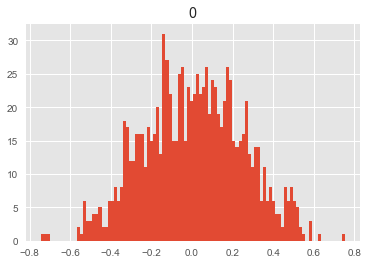

In [74]:
pd.DataFrame(np.random.normal(scale=0.25, size=(1000,1))).hist(bins=100)

In [18]:
import importlib
utils = importlib.reload(utils)

In [50]:
from utils import SmoothLikelihood4

D = X_train.copy()
G = X_test.copy()
slk = SmoothLikelihood4(['gender','MAP'], 0.5, kf=StratifiedKFold(random_state=111111, n_splits=20, shuffle=True),
                        alpha=13,
                       seed=10,
                        std=0.0013
                       )
d1 = slk.fit_transform(X_train, y_train)
g1 = slk.transform(X_test)

In [51]:
D['slk']=d1
G['slk']=g1

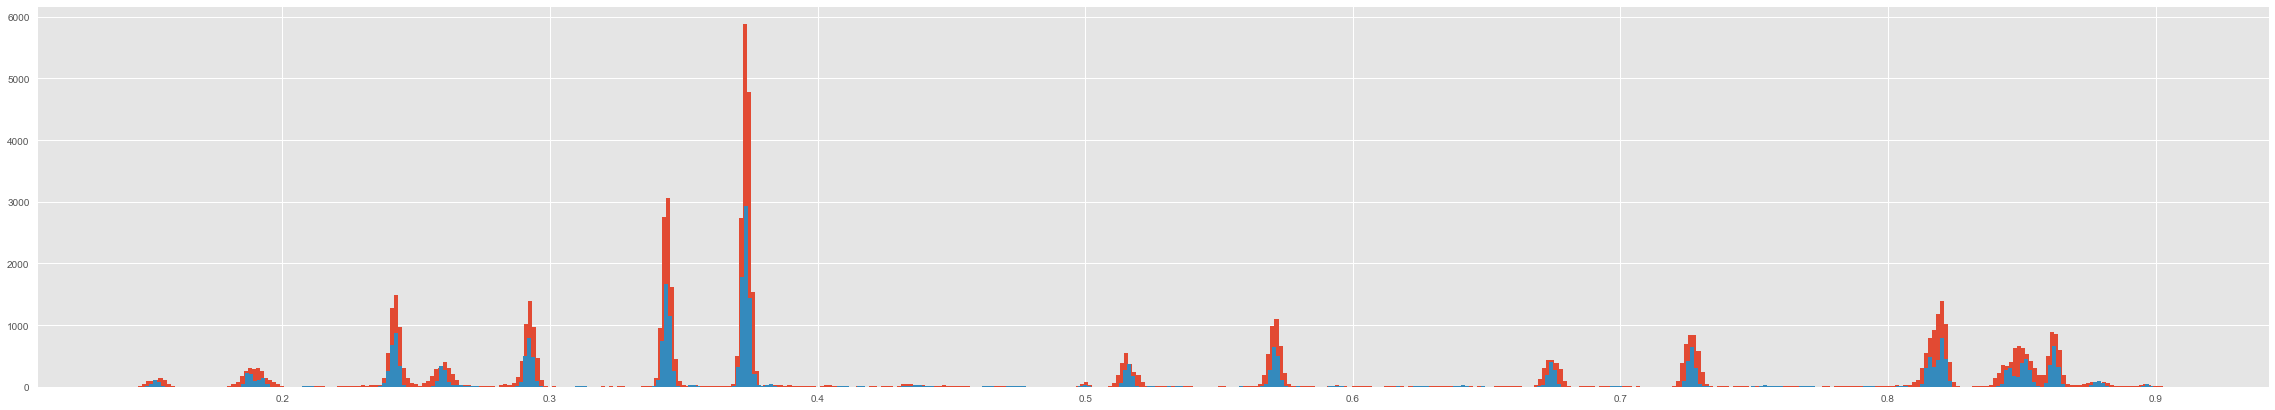

In [52]:
plt.figure(figsize=(40,7))
D['slk'].hist(bins=500)
G['slk'].hist(bins=500)

In [62]:
D.groupby(['ap_hi_group', 'age_group', 'gender'])['slk'].std().max()

0.054392829322042147

In [ ]:
params = {
     'colsample_bytree': 0.95,
     'gamma': 0.55,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,

    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(xgb.XGBClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model2-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()

In [ ]:
import lightgbm as lgb

params = {
    'colsample_bytree': 0.95,
#      'gamma': 0.55,
     'learning_rate': 0.02,
#      'max_depth': 5,
     'num_leaves': 2**5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,
       
    'nthread': 4,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(wrap_classifier(lgb.LGBMClassifier(**params)),
              X_train,
              y_train,
              X_test,
              model_name="model3-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()

In [ ]:
clf = xgb.XGBClassifier(
        learning_rate=0.06,
        n_estimators=114,
        max_depth=5,
        min_child_weight=5,
        gamma=0.3,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=9,
        reg_lambda=1.4,
        nthread=4,
       
        seed=1111
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model4-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()

In [ ]:
clf = xgb.XGBClassifier(
        learning_rate=0.07,
        n_estimators=218,
        max_depth=3,
        min_child_weight=5,
        gamma=0.2,
        subsample=0.6,
        colsample_bytree=0.55,
        reg_alpha=0,
        reg_lambda=1.0,
        nthread=4,
        tree_method='hist',
        grow_policy='lossguide',
       
        seed=2222
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model5-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()

In [ ]:
clf = lgb.LGBMClassifier(
        learning_rate=0.07,
        n_estimators=218,
#         max_depth=3,
        num_leaves=2**3,
        min_child_weight=5,
        subsample=0.6,
        colsample_bytree=0.55,
        reg_alpha=0,
        reg_lambda=1.0,
        nthread=4,
       
        seed=2222
    )

utils.execute_model(wrap_classifier(clf),
              X_train,
              y_train,
              X_test,
              model_name="model6-",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler  

# scaler = StandardScaler()  
# X = pd.concat((X_train, X_test), axis=0)
# scaler.fit(X)
# gc.collect()

# clf = MLPClassifier(solver='adam', activation='relu', learning_rate = 'adaptive', tol = 1e-5,
#                     hidden_layer_sizes=(8, 3), random_state=1100)

# utils.execute_model(clf,
#               scaler.transform(X_train),
#               y_train,
#               scaler.transform(X_test) ,
#               model_name="model4",
#               mean_columns = mean_columns,
#               use_columns = use_columns,
#               n_splits=15,
#               n_folds=10,
#               alpha=20
#              )
# gc.collect()

In [ ]:
models = ['model1','model2','model3']
result1 = utils.merge_models(models, method='mean')
pd.DataFrame(result1).to_csv('models1234_mean.csv', index=False, header=False, sep=';')

In [14]:
models = ['model1-','model2-','model3-','model4-','model5-','model6-', 'KERAS_1']
result1 = utils.merge_models(models, method='mean')
pd.DataFrame(result1).to_csv('models1234-_mean.csv', index=False, header=False, sep=';')
# 0.537888791163	0.53818930228	0.537494736443	0.537712095482


model1-
0.537553381572	0.537733068239	0.537553381572	0.537733068239

model2-
0.537831773564	0.53807213291	0.537524474477	0.537703991975

model4-
0.53846724856	0.538554524067	0.537529911476	0.537639039745

model5-
0.538162581274	0.538295101959	0.537522865028	0.537621200081

model6-
0.538185884402	0.538317455013	0.537540292521	0.537629699993

KERAS_1
0.542922511253	0.542222618912	0.537574147349	0.537641333568


In [ ]:
# 0.537519393165	0.537619764695 = 0.5432057 * new log features

# 0.538126862768	0.538047373071 = 0.5431843
# 0.538084892954	0.538027778903 = 0.5433475
# 0.538157706723	0.538186899005 = 0.5430039 # без стасо-колонок
# 0.537450021945	0.537849282831 = 0.5434434
# 0.537513993512	0.537749328355 = 0.5433418

# 0.537790804547	0.538014148853 = 0.5438901 # overfit full

# 0.537561506209                   = 0.5432193

# 0.537727687638	0.537773366433 = 0.5437636
# 0.537662820586	0.538506869394 = 0.5433681
# 0.537639730851	0.538322959718 = 0.5436416 # overfit due to smoke leak
# 0.537723242359	0.538418956272 = 0.5433819
# 0.537697918691	0.538454608940 = 0.5435035
# 0.537797383673	0.538468964022 = 0.5433098
# 0.537998452494	0.538697384187 = 0.5433633
# 0.538141859286	0.538727942758 = 0.5434983

In [ ]:
%%time
params = {
    'learning_rate': 0.1,
    'n_estimators': 50,
    
    'n_jobs': 8,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(),
              X_train,
              y_train,
              mean_columns = mean_columns,
              use_columns = use_columns,
              n_folds=10,
              alpha=13,
             )
gc.collect()

In [ ]:
# 0.537735274001	0.537762262313 = 0.5439345
# 0.538040557134	0.538014744278 = 0.5436639
# 0.5374	0.5374                 = 0.5440495
# 0.537603843701	0.537606129043 = 0.5448082

# Со столбцами Стаса альфа=20
# 0.537387582699	0.537559051543 = 0.5482682

# 0.537684932504	0.537640948053 = 0.5514443 добавил один столбик "по Стасу"
# 0.537748490027	0.537673097079 = 0.5517563 20 фолдов для подсчета среднего

# Без них
# 0.538947547578	0.538808662263 = 0.5441786
# 0.538231869380	0.538120316604 = 0.5435621